In [3]:
import pandas as pd
import os
import librosa
import librosa.display
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import os
from scipy.io import wavfile
import seaborn as sns
from tensorflow.keras.layers import LSTM
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
import noisereduce as nr
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
import tensorflow.keras as keras

Loading the audio files using librosa library.

In [4]:
# Loading normal
normal=os.listdir("heart_sound/heart_sound/train/healthy")[:650]

# Loading abnormal
abnormal=os.listdir("heart_sound/heart_sound/train/unhealthy")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'heart_sound/heart_sound/train/healthy'

In [3]:
normal_sounds=[]
normal_duration=[]
sample_rate=22050
for sound in normal:
    audio, sample_rate = librosa.load(os.path.join("heart_sound/heart_sound/train/healthy/"+sound),sr=sample_rate,mono=True, res_type='kaiser_fast')
    normal_sounds.append(audio)
    normal_duration.append(librosa.core.get_duration(audio,sample_rate))

In [4]:
normal_df= pd.DataFrame()
normal_df['audio']= normal_sounds
normal_df['class']= 0
normal_df['file_name']=normal
normal_df['duration']=normal_duration

In [5]:
abnormal_sounds=[]
abnormal_duration=[]
for sound in abnormal:
    audio, sample_rate = librosa.load(os.path.join("heart_sound/heart_sound/train/unhealthy/"+sound),sr=sample_rate,mono=True, res_type='kaiser_fast')
    abnormal_sounds.append(audio)
    abnormal_duration.append(librosa.core.get_duration(audio,sample_rate))

In [6]:
abnormal_df= pd.DataFrame()
abnormal_df['audio']= abnormal_sounds
abnormal_df['class']= 1
abnormal_df['file_name']=abnormal
abnormal_df['duration']=abnormal_duration

In [7]:
heart_sound= pd.concat([normal_df, abnormal_df], ignore_index=True, sort=False)

In [8]:
heart_sound.shape

(1315, 4)

In [9]:
heart_sound.head()

,audio,class,file_name,duration
0,"[0.0010432453, 0.0014091895, 0.0018182063, 0.0...",0,b0123.wav,8.000000
1,"[-0.090585805, -0.09565477, -0.099753596, -0.1...",0,e01947.wav,8.119002
2,"[-0.0010384485, -0.0014539795, -0.0018792074, ...",0,e00481.wav,17.966032
3,"[0.004732245, 0.0044500255, 0.0040681735, 0.00...",0,e00495.wav,15.101043
4,"[-0.012747022, -0.0134038385, -0.013926082, -0...",0,e01006.wav,20.381043


We have 4 features and 1315 observations. 

* Audio represents the audio files as a floating point time series.
  The audio file is already normalized, all data points are between 1 and -1.

* Class represents the heart's condition, 1 if the condition is abnormal and 0 if the condition is normal.

* File name represents the name of the audio file.

* Duration represents the duration of audio file in seconds.

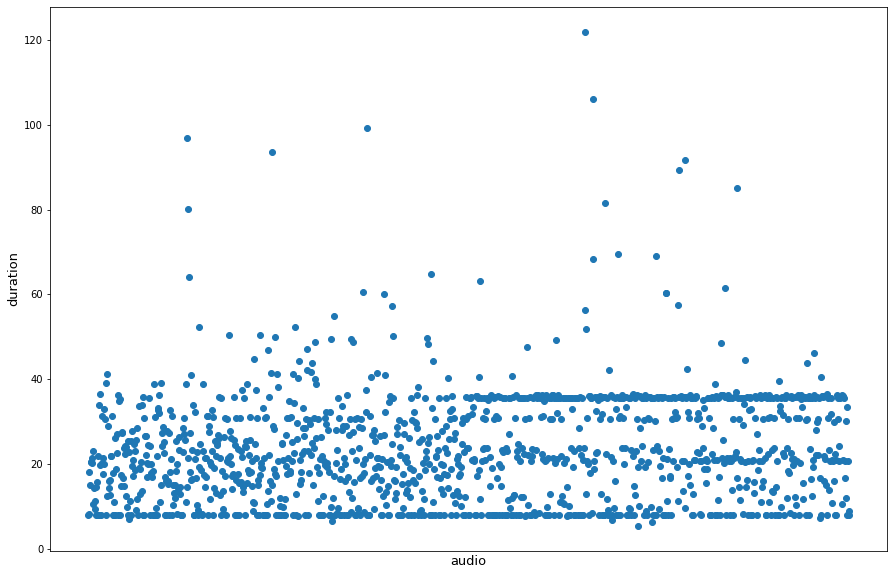

In [10]:
plt.rcParams["figure.figsize"] = (15,10)
video = heart_sound['file_name']
duration = heart_sound['duration']
plt.xlabel("audio",fontsize=13);
plt.ylabel("duration",fontsize=13);
plt.xticks([])
plt.scatter(video,duration)
plt.show()

Dropping audio files of 40 seconds or more.

In [11]:
heart_sound=heart_sound[heart_sound['duration']<40]
heart_sound=heart_sound.reset_index(drop=True)

Visualizing class distribution

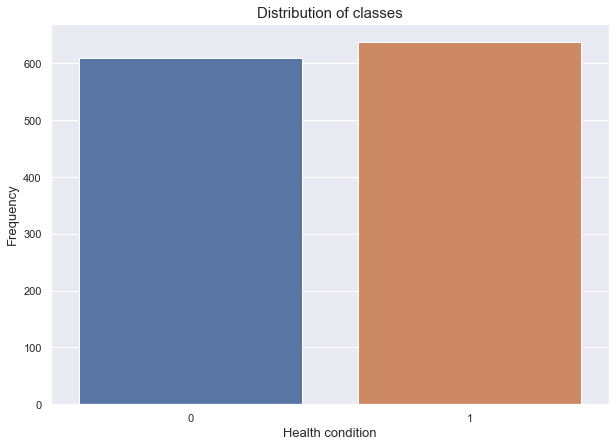

In [12]:
sns.set(rc={'figure.figsize':(10,7)})
ax = sns.countplot(x="class",data=heart_sound);
ax.set_xlabel("Health condition",fontsize=13);
ax.set_ylabel("Frequency",fontsize=13);
ax.set_title('Distribution of classes',fontsize=15);
plt.savefig('images/Figure1.png', dpi=200)

The plot shows that the classes are balanced.

The waveplot shows the change in air pressure at a certain time.

The following plot is a waveplot for a normal heart sound.

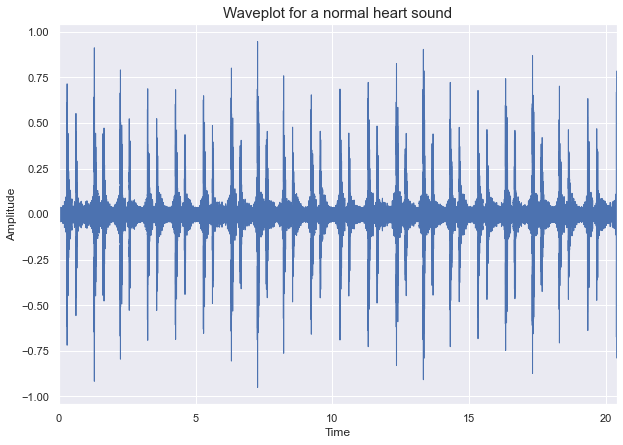

In [13]:
librosa.display.waveplot(heart_sound['audio'][4],sr=sample_rate);
plt.ylabel("Amplitude")
plt.title('Waveplot for a normal heart sound', fontsize=15);

Play the audio directly in the notebook.

The following plot is a waveplot for an abnormal heart sound.

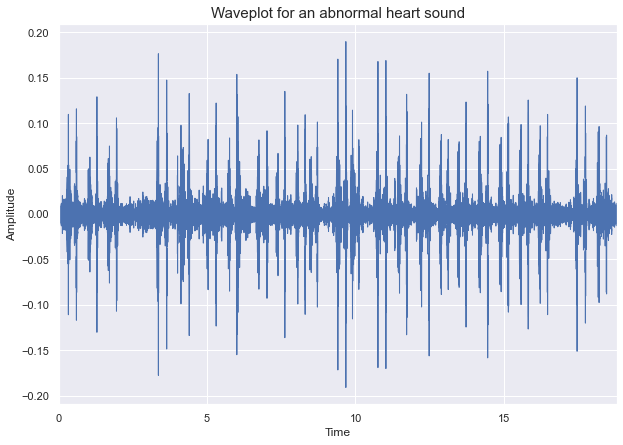

In [15]:
librosa.display.waveplot(heart_sound['audio'][1002],sr=sample_rate);
plt.ylabel("Amplitude")
plt.title('Waveplot for an abnormal heart sound', fontsize=15);

Play the audio directly in the notebook.

In [30]:
def reducenoise(audio):
    return nr.reduce_noise(y=audio, sr=sample_rate)

In [31]:
heart_sound['audio']=heart_sound['audio'].apply(lambda x:reducenoise(x))

Making all audio files the same length

In [32]:
max1 = len(heart_sound['audio'][0])
for i in range(len(heart_sound)):
    if max1< len(heart_sound['audio'][i]):
        max1=len(heart_sound['audio'][i])

In [33]:
audio_padded=[]
for i in range(len(heart_sound)):
    n=max1-len(heart_sound['audio'][i])
    newdf=np.pad(heart_sound['audio'][i],(0,n),'constant')
    audio_padded.append(newdf)

In [34]:
heart_sound['audio_padded']=audio_padded

# Neural Networks

We will try 3 neural networks to see which one gives the best performance.
- Feedforward neural network.
- LSTM neural network.
- CNN neural network.

## Feedforward Neual Network

Extracting features

In [35]:
extracted_features=[]
for audio in heart_sound['audio']:
        data=features_extractor(audio,sample_rate)
        extracted_features.append(data)

In [36]:
heart_sound['extracted_features']=extracted_features

In [65]:
x=np.array(heart_sound['extracted_features'].tolist())
y=np.array(heart_sound['class'].tolist())

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3, random_state=42)

Building the network which consists of an input layer, 2 hidden layers and an output layer.

In [66]:
ann_model=Sequential()

ann_model.add(Dense(100,input_shape=(40,)))
ann_model.add(Activation('tanh'))
ann_model.add(Dropout(0.5))

ann_model.add(Dense(100))
ann_model.add(Activation('tanh'))
ann_model.add(Dropout(0.5))

ann_model.add(Dense(1))
ann_model.add(Activation('sigmoid'))
ann_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 100)               4100      
                                                                 
 activation_3 (Activation)   (None, 100)               0         
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 100)               10100     
                                                                 
 activation_4 (Activation)   (None, 100)               0         
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                

In [67]:
ann_model.compile(loss='binary_crossentropy',metrics=['Recall'],optimizer='adam')

In [68]:
num_epochs = 40
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification1.hdf5', verbose=1, save_best_only=True)
start = datetime.now()

history_ann=ann_model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/40
 1/28 [>.............................] - ETA: 14s - loss: 0.7482 - recall: 0.6111
Epoch 00001: val_loss improved from inf to 0.73353, saving model to saved_models/audio_classification1.hdf5
28/28 [==============================] - 1s 9ms/step - loss: 0.8519 - recall: 0.5122 - val_loss: 0.7335 - val_recall: 1.0000
Epoch 2/40
 1/28 [>.............................] - ETA: 0s - loss: 0.9054 - recall: 0.7368
Epoch 00002: val_loss improved from 0.73353 to 0.72313, saving model to saved_models/audio_classification1.hdf5
28/28 [==============================] - 0s 3ms/step - loss: 0.8692 - recall: 0.5033 - val_loss: 0.7231 - val_recall: 1.0000
Epoch 3/40
 1/28 [>.............................] - ETA: 0s - loss: 0.7901 - recall: 0.8889
Epoch 00003: val_loss improved from 0.72313 to 0.62238, saving model to saved_models/audio_classification1.hdf5
28/28 [==============================] - 0s 3ms/step - loss: 0.7984 - recall: 0.5924 - val_loss: 0.6224 - val_recall: 0.7037
Epoch 4/40
 1/28

In [69]:
score= ann_model.evaluate(X_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test recall:', score[1])

Test loss: 0.4849853813648224
Test recall: 0.9444444179534912


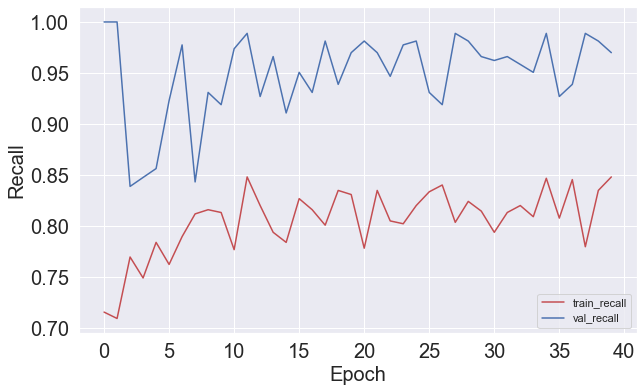

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history_ann.history['recall']), 'r', label='train_recall')
ax.plot(np.sqrt(history_ann.history['val_recall']), 'b' ,label='val_recall')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Recall', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

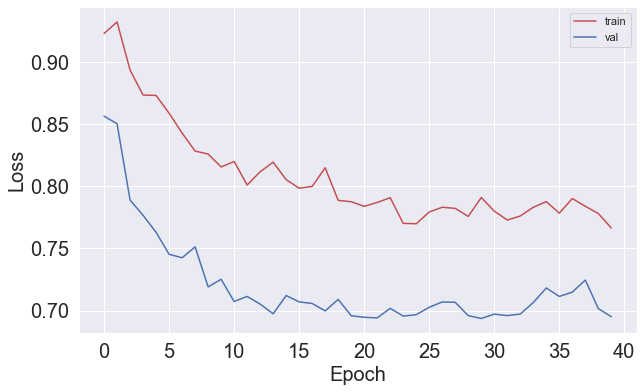

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history_ann.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history_ann.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

Feedforward neural network achieved recall of 0.94 on the test set.

## LSTM Neural Network

Extracting features for LSTM neural network.

In [44]:
mfcc_abnormal={'mfcc':[]}
samples_per_track = sample_rate * 40
num_segment=40
hop_length=512
samples_per_segment = int(samples_per_track / num_segment)
num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

heart_sound_ab=heart_sound[heart_sound['class']==1]
for sound in heart_sound_ab['audio_padded']:
    for s in range(num_segment):
        start = samples_per_segment * s
        finish = start + samples_per_segment
        mfcc= librosa.feature.mfcc(y=sound[start:finish], sr=sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)
        mfcc=mfcc.T
        if len(mfcc) == num_mfcc_vectors_per_segment:
            mfcc_abnormal['mfcc'].append(mfcc.tolist())  

abnormal_features=pd.DataFrame.from_dict(mfcc_abnormal)
abnormal_features['class']=1

In [45]:
mfcc_normal={'mfcc':[]}
heart_sound_an=heart_sound[heart_sound['class']==0]
for sound in heart_sound_an['audio_padded']:
    for s in range(num_segment):
        start = samples_per_segment * s
        finish = start + samples_per_segment
        mfcc= librosa.feature.mfcc(y=sound[start:finish], sr=sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)
        mfcc=mfcc.T
        if len(mfcc) == num_mfcc_vectors_per_segment:
            mfcc_normal['mfcc'].append(mfcc.tolist())  

normal_features=pd.DataFrame.from_dict(mfcc_normal)
normal_features['class']=0

In [46]:
heart_sound_LSTM= pd.concat([abnormal_features, normal_features], ignore_index=True, sort=False)

In [47]:
X2=np.array(heart_sound_LSTM['mfcc'].tolist())
y2=np.array(heart_sound_LSTM['class'].tolist())

In [48]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_test2, y_test2, test_size=0.5, random_state=42)

In [49]:
input_shape = (X_train2.shape[1],X_train2.shape[2])

Building the network which consists of an input layer, 3 hidden layers and an output layer.

In [56]:
lstm_model=Sequential()
lstm_model.add(keras.layers.LSTM(64,input_shape = (input_shape), return_sequences=True))
lstm_model.add(keras.layers.LSTM(64))
lstm_model.add(keras.layers.Dropout(0.3))
lstm_model.add(keras.layers.Dense(128, activation='relu'))
lstm_model.add(keras.layers.Dropout(0.5))
lstm_model.add(keras.layers.Dense(1, activation='sigmoid'))
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 44, 64)            19968     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 128)               8320      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 61,441
Trainable params: 61,441
Non-trai

In [57]:
lstm_model.compile(loss='binary_crossentropy',metrics=['Recall'],optimizer='sgd')

In [58]:
num_epochs = 20
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification2.hdf5',
                               verbose=1, save_best_only=True)

start = datetime.now()
lstm_history=lstm_model.fit(X_train2, y_train2, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_val2, y_val2), callbacks=[checkpointer], verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/20
1215/1216 [============================>.] - ETA: 0s - loss: 0.6907 - recall: 0.6787
Epoch 00001: val_loss improved from inf to 0.69379, saving model to saved_models/audio_classification2.hdf5
1216/1216 [==============================] - 53s 41ms/step - loss: 0.6907 - recall: 0.6789 - val_loss: 0.6938 - val_recall: 1.0000
Epoch 2/20
1216/1216 [==============================] - ETA: 0s - loss: 0.6882 - recall: 0.6429
Epoch 00002: val_loss improved from 0.69379 to 0.68075, saving model to saved_models/audio_classification2.hdf5
1216/1216 [==============================] - 51s 42ms/step - loss: 0.6882 - recall: 0.6429 - val_loss: 0.6808 - val_recall: 0.5822
Epoch 3/20
1215/1216 [============================>.] - ETA: 0s - loss: 0.6906 - recall: 0.6759
Epoch 00003: val_loss did not improve from 0.68075
1216/1216 [==============================] - 52s 42ms/step - loss: 0.6906 - recall: 0.6759 - val_loss: 0.6895 - val_recall: 0.9864
Epoch 4/20
1215/1216 [==========================

In [59]:
score = lstm_model.evaluate(X_test2,y_test2, verbose=0)
print('Test loss:', score[0])
print('Test recall:', score[1])

Test loss: 0.6529991030693054
Test recall: 0.9620048403739929


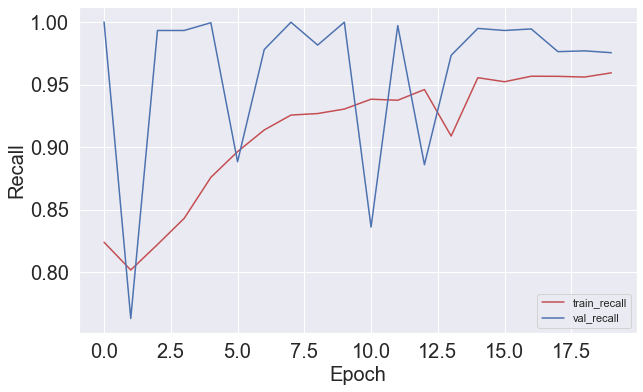

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lstm_history.history['recall']), 'r', label='train_recall')
ax.plot(np.sqrt(lstm_history.history['val_recall']), 'b' ,label='val_recall')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Recall', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

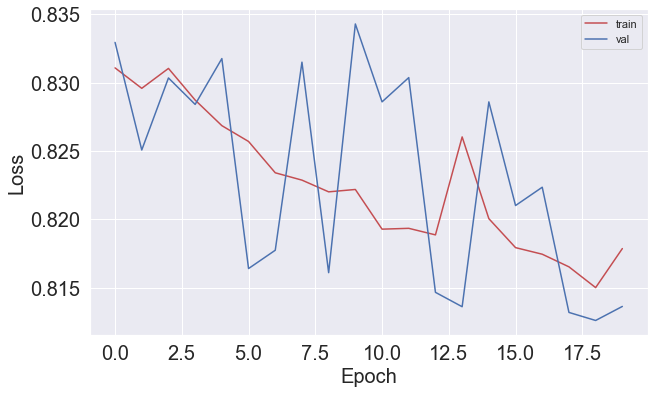

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lstm_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(lstm_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

LSTM neural network achieved recall of 0.96 on the test set.